# Phase 2 Project Workbook

In [3361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle
from datetime import datetime
from scipy import stats                                                                 
from scipy.stats import f_oneway                                                               #ANOVA
from statsmodels.formula.api import ols                                                        #Regression Summary
from statsmodels.stats.multicomp import pairwise_tukeyhsd        
from statsmodels.stats import weightstats as stests                                            #Z-test code
from statsmodels.stats.proportion import proportions_ztest                                     #Proportions z-test
from sklearn.linear_model import LinearRegression                                              #Simple & MultiLinear Regression
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_regression, mutual_info_regression     
from sklearn.preprocessing import PolynomialFeatures, StandardScaler                           #Multilinear Regression
from sklearn import metrics                                                                    #MAE, MSE
from sklearn.model_selection import train_test_split
%matplotlib inline 
pd.set_option('display.max_columns', 100)

## Reading & Checking Data

In [3283]:
%pwd

'C:\\Users\\User\\Documents\\Flatiron\\Repository\\flatiron-p2-housing\\trials'

In [3284]:
df = pd.read_csv('C:\\Users\\User\\Documents\\Flatiron\\Repository\\flatiron-p2-housing\\data\\kc_house_data_train.csv')
print(df.shape)
df.head()

(17290, 22)


Unnamed: 0          id             date      price  bedrooms  bathrooms  \
0           0  2591820310  20141006T000000   365000.0         4       2.25   
1           1  7974200820  20140821T000000   865000.0         5       3.00   
2           2  7701450110  20140815T000000  1038000.0         4       2.50   
3           3  9522300010  20150331T000000  1490000.0         3       3.50   
4           4  9510861140  20140714T000000   711000.0         3       2.50   

   sqft_living  sqft_lot  floors  waterfront  view  condition  grade  \
0         2070      8893     2.0           0     0          4      8   
1         2900      6730     1.0           0     0          5      8   
2         3770     10893     2.0           0     2          3     11   
3         4560     14608     2.0           0     2          3     12   
4         2550      5376     2.0           0     0          3      9   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0        2070              0      1986             0    98058  47.4388   
1        1830           1070      1977             0    98115  47.6784   
2        3770              0      1997             0    98006  47.5646   
3        4560              0      1990             0    98034  47.6995   
4        2550              0      2004             0    98052  47.6647   

      long  sqft_living15  sqft_lot15  
0 -122.162           2390        7700  
1 -122.285           2370        6283  
2 -122.129           3710        9685  
3 -122.228           4050       14226  
4 -122.083           2250        4050

In [3285]:
# #Dropping the Unnamed: 0 column
# print(df.shape)
# df = df.drop(['Unnamed: 0'], axis = 1)
# df.describe()

In [3286]:
#Checking datatypes and column names
#There are no null type data points in our dataframe (yay!)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     17290 non-null  int64  
 1   id             17290 non-null  int64  
 2   date           17290 non-null  object 
 3   price          17290 non-null  float64
 4   bedrooms       17290 non-null  int64  
 5   bathrooms      17290 non-null  float64
 6   sqft_living    17290 non-null  int64  
 7   sqft_lot       17290 non-null  int64  
 8   floors         17290 non-null  float64
 9   waterfront     17290 non-null  int64  
 10  view           17290 non-null  int64  
 11  condition      17290 non-null  int64  
 12  grade          17290 non-null  int64  
 13  sqft_above     17290 non-null  int64  
 14  sqft_basement  17290 non-null  int64  
 15  yr_built       17290 non-null  int64  
 16  yr_renovated   17290 non-null  int64  
 17  zipcode        17290 non-null  int64  
 18  lat   

### First Observations of Data
- **id:** Treat as a string since the number is exponentially large.
- **date:** Convert to UTC and extrapolate year from the data.
- **price:** Prediction target value. Leave alone for now.
- **bedrooms:** Number of bedrooms. Possible outliers with at least one home having 33 bedrooms.
- **bathrooms:** Leave alone for now. Float data type suggests half bathrooms (w/o tub or shower).
- **sqft_living:** Square footage of the house. 
- **sqft_lot:** Possible outliers with one property having 14,000 sqft, yet only costing about 240,000k.
- **floors:** Possible mezzanines, banisters, catwalks, attics, sub-basements, or garage floors that are float vals.
- **waterfront:** Leave alone for now.
- **view:** Leave alone for now.
- **condition:** Value unknown if higher = better or reverse.
- **sqft_above:** Square footage if house has a basement most likely. Combine with basement for feature later.
- **sqft_basement:** Could be useful later on. Leave alone for now. Possible feature later.
- **yr_renovated:** Could prove useful to get a value for years since renovation.
- **zipcode:** Convert to string to prevent issues later?
- **sqft_living15:** Closely correlated to sqft_living. Worth keeping around as we'll see later in the correlation chart.

In [3287]:
#Already knew this existed as an extreme outlier in the dataframe. This could be either a data entry error, 
#a categorical error (commercial space vs home), or an actual castle...
df.bedrooms.sort_values(ascending = False)

8597     33
2356     11
11181    10
3680     10
17114    10
         ..
3609      0
15733     0
3032      0
483       0
1120      0
Name: bedrooms, Length: 17290, dtype: int64

## Initial Visualizations (a peek)

**Takeaways:**
- The majority of homes built are on the newer end between 11-20 years old

''

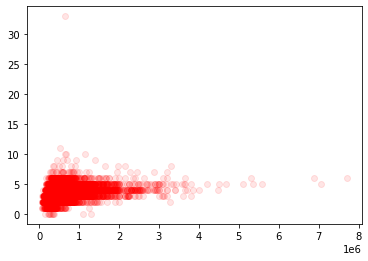

In [3288]:
#Checking the outlier values in Bedrooms
fig, ax = plt.subplots()
ax.scatter(df['price'], df['bedrooms'], alpha = 0.1, color = 'r')
;

**Takeaways:**
- Doesn't look at first glance that bedrooms by themself have a huge impact on sale price. But let's get rid of that 33 bedroom value by imputing the mean # of bedrooms since the sale price is also on the low side.

In [3289]:
#Take the mean and use for the value with 33 bedrooms
df['bedrooms'].mean()

3.3724696356275303

''

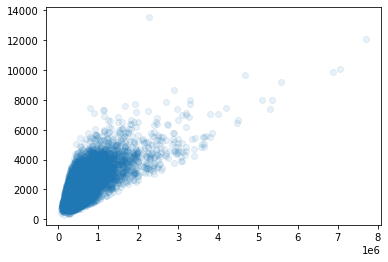

In [3290]:
#Checking the outlier values in sqft_living
fig, ax = plt.subplots()
ax.scatter(df['price'], df['sqft_living'], alpha = 0.1)
;

**Takeaways:**
- There is a positive correlation between **price** and **sqft_living** (as expected)
- There is also an outlier at around a price of $240,000 although the square feet of living space is almost 14,000

In [3291]:
#Looking at the max sqft_living to isolate that outlier
df[['sqft_living', 'price']].sort_values(by = 'sqft_living', ascending = False)

sqft_living      price
3275         13540  2280000.0
10366        12050  7700000.0
6903         10040  7062500.0
7519          9890  6885000.0
15816         9640  4668000.0
...            ...        ...
6345           390   245000.0
13989          390   228000.0
2430           384   265000.0
7263           370   276000.0
10067          290   142000.0

[17290 rows x 2 columns]

''

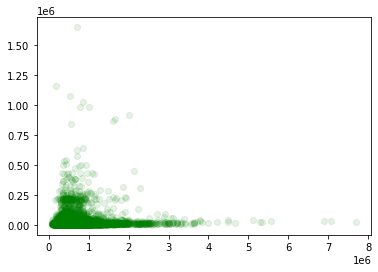

In [3292]:
#Checking the outlier values of sqft_lot
fig, ax = plt.subplots()
ax.scatter(df['price'], df['sqft_lot'], alpha = 0.1, color = 'g')
;

**Takeaways:** 
- Again, we have huge outlier values for properties with a low average price. These might need to be imputed, 
but we should see where they are.


### Histogram of Price Distribution

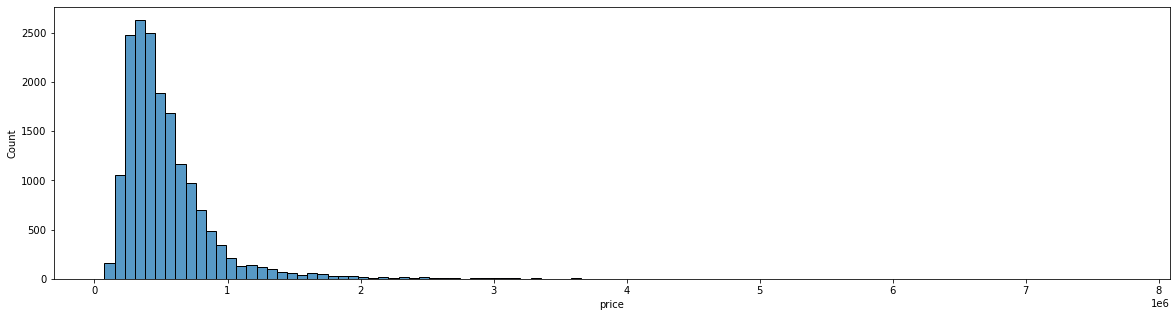

In [3293]:
plt.figure(figsize = (20, 5))    
sns.histplot(data = df['price'], bins = 100)

# plt.savefig('price_dist.png', dpi = 100)
plt.show()

**Takeaways:**
- The pricing data is skewed to the right positively, yet quite a few outliers still exist. Such a spread and wide price range could be dependent on a wide range of factors however.
- Let's log the price target and view in a graph to see as a normal distribution.

#### Log Transformation on Price to View as Normal Distribution

Skew is: 0.44658171492588483


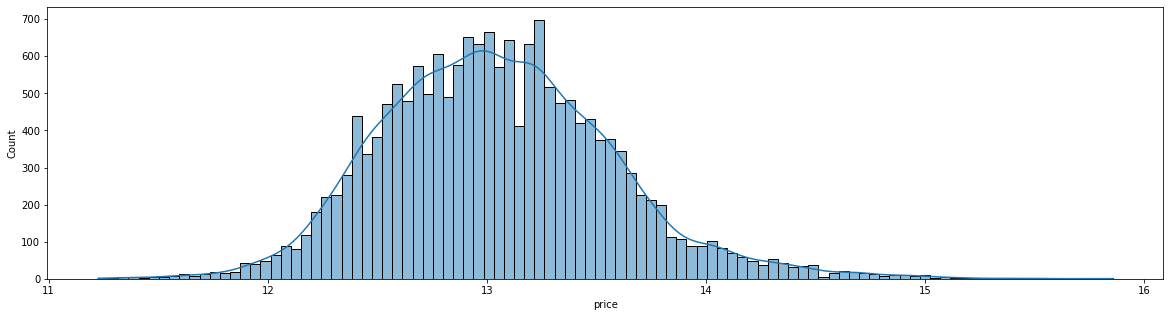

In [3294]:
target = np.log(df['price'])

plt.figure(figsize=(20,5))
sns.histplot(data = target, bins=100, kde=True)
print ("Skew is:", target.skew())
plt.show()

## Data Cleaning

- Preparation and taking care of abnormal data types
- Properties having 0 bathrooms may be errored. Those with 0 bedrooms may be listed as studio apartments, but there are some outliers with larger square footage that still have issues with the number of bedrooms and bathrooms in comparison to sqft.
- Check for issues with sqft_lot values with high numbers despite selling for low prices.

In [3295]:
#Homes with zero bathrooms in relation to sqft of living space and bedrooms
df[['bathrooms', 'sqft_living', 'bedrooms']].sort_values(by= 'bathrooms', ascending = True)

bathrooms  sqft_living  bedrooms
12982       0.00          690         1
5424        0.00         1470         0
1120        0.00         3064         0
10067       0.00          290         0
483         0.00         2460         0
...          ...          ...       ...
15816       6.75         9640         5
3425        7.50         4050         9
7519        7.75         9890         6
10366       8.00        12050         6
3275        8.00        13540         7

[17290 rows x 3 columns]

In [3296]:
#Do a drop on the subset if > 80000 and price is < 1,000,000
df[['sqft_lot', 'zipcode', 'price']].sort_values(by = 'sqft_lot', ascending = False)

sqft_lot  zipcode     price
718     1651359    98022  700000.0
11616   1164794    98014  190000.0
13460   1074218    98027  542500.0
16243   1024068    98045  855000.0
13543    982998    98058  998000.0
...         ...      ...       ...
5741        649    98106  259950.0
5944        638    98112  516500.0
2682        635    98106  256950.0
644         600    98116  367500.0
3407        572    98106  250000.0

[17290 rows x 3 columns]

## Data Transformation

- Let's create a deep copy of the original dataframe before we start modifying the housing data.

In [3297]:
housing = df.copy()

In [3298]:
housing.head()

Unnamed: 0          id             date      price  bedrooms  bathrooms  \
0           0  2591820310  20141006T000000   365000.0         4       2.25   
1           1  7974200820  20140821T000000   865000.0         5       3.00   
2           2  7701450110  20140815T000000  1038000.0         4       2.50   
3           3  9522300010  20150331T000000  1490000.0         3       3.50   
4           4  9510861140  20140714T000000   711000.0         3       2.50   

   sqft_living  sqft_lot  floors  waterfront  view  condition  grade  \
0         2070      8893     2.0           0     0          4      8   
1         2900      6730     1.0           0     0          5      8   
2         3770     10893     2.0           0     2          3     11   
3         4560     14608     2.0           0     2          3     12   
4         2550      5376     2.0           0     0          3      9   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0        2070              0      1986             0    98058  47.4388   
1        1830           1070      1977             0    98115  47.6784   
2        3770              0      1997             0    98006  47.5646   
3        4560              0      1990             0    98034  47.6995   
4        2550              0      2004             0    98052  47.6647   

      long  sqft_living15  sqft_lot15  
0 -122.162           2390        7700  
1 -122.285           2370        6283  
2 -122.129           3710        9685  
3 -122.228           4050       14226  
4 -122.083           2250        4050

In [3299]:
#Turn id into a string to prevent any numerical issues.
df['id'] = df['id'].astype('str')

#Turn zipcode into a string to prevent any numerical issues.
df['zipcode'] = df['zipcode'].astype('str')

#Convert the date column to something workable. We'll first use UTC then strip the year out afterwards.
df['date'] = pd.to_datetime(df['date'], utc = True)

#Taking care of the 33 bedroom property by imputing the mean number of bedrooms.
df['bedrooms'] = np.where(df['bedrooms'] > 30, df['bedrooms'].mean(), df['bedrooms'])

#Taking care of any properties with less than .5 baths. Using .75 as that code for baths has a shower.
df['bathrooms'] = np.where(df['bathrooms'] < .75, .75, df['bathrooms'])

## Feature Engineering

In [3300]:
#Transforming the data from the date to get and extract the year in order to calcuate the age of the house.
df['year_sold'] = pd.to_datetime(df['date']).dt.date.astype('datetime64[ns]')

#Convert bedrooms to into to account for the mean transformation we did previously for the 33 bedroom value.
df['bedrooms'] = df['bedrooms'].astype(int)

#Create a column for whether or not a property has a basement
df['has_basement'] = np.where(df['sqft_basement'] > 0, 1, 0)

#Feature Engineering to extrapolate the year sold from the convoluted date format.
df['year_sold'] = pd.DatetimeIndex(df['year_sold']).year # extract only year

#Feature Engineering the age of the home
df['age_built'] = (df['year_sold'] - df['yr_built']).astype(int)
df['age_built'] = (df['age_built'] + 6) #bring up to 2021 values

#Feature Engineering the time since the last renovation on home. No renovation will treat build year as the value.
reno_cond = [df['yr_renovated'] == 0, df['yr_renovated'] != 0]
reno_choices = [df['year_sold'] - df['yr_built'], df['year_sold'] - df['yr_renovated']]
df['last_reno'] = np.select(reno_cond, reno_choices)
df['last_reno'] = (df['last_reno'] + 6) #bring up to 2021 values

#Get month property sold
df['month_sold'] = pd.DatetimeIndex(df['date']).month

#Feature Engineering to convert months to seasons (1=Winter, 2=Spring, 3=Summer, 4=Fall)
season_cond = [df['month_sold'] <= 3, (df['month_sold'] >= 4) & (df['month_sold'] <=6), 
               (df['month_sold'] >= 7) & (df['month_sold'] <=9), (df['month_sold'] >= 10) & (df['month_sold'] <=12)]
season_choices = [1, 2, 3, 4] 
df['season_sold'] = np.select(season_cond, season_choices)

#Simple Boolean answer whether the home was renovated as (True/False)
choices_reno_TF = [0, 1] #0 = True
df['was_reno'] = np.select(reno_cond, choices_reno_TF)

#Feature Engineering columns that show the ratio of beds and bath to home
df['bed_sqft_ratio'] = df['bedrooms'] / df['sqft_living']
df['bath_sqft_ratio'] = df['bathrooms'] / df['sqft_living']
df['floors_sqft_ratio'] = df['floors'] / df['sqft_living']

#Feature Engineering for grade values attributed to letter grade 
df['grade_lvl'] = df.grade.apply(lambda x: 'S+' if x == 13 else (
                                           'S' if x == 12 else (
                                           'S-' if x == 11 else (
                                           'A+' if x == 10 else (
                                           'A' if x ==  9 else (
                                           'A-' if x == 8 else (
                                           'B+' if x == 7 else (
                                           'B' if x == 6 else (
                                           'B-' if x == 5 else (
                                           'C+' if x == 4 else (
                                           'C' if x == 3 else (
                                           'C-' if x == 2 else (
                                           'D')))))))))))))

In [3301]:
df.head()

Unnamed: 0          id                      date      price  bedrooms  \
0           0  2591820310 2014-10-06 00:00:00+00:00   365000.0         4   
1           1  7974200820 2014-08-21 00:00:00+00:00   865000.0         5   
2           2  7701450110 2014-08-15 00:00:00+00:00  1038000.0         4   
3           3  9522300010 2015-03-31 00:00:00+00:00  1490000.0         3   
4           4  9510861140 2014-07-14 00:00:00+00:00   711000.0         3   

   bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  \
0       2.25         2070      8893     2.0           0     0          4   
1       3.00         2900      6730     1.0           0     0          5   
2       2.50         3770     10893     2.0           0     2          3   
3       3.50         4560     14608     2.0           0     2          3   
4       2.50         2550      5376     2.0           0     0          3   

   grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode      lat  \
0      8        2070              0      1986             0   98058  47.4388   
1      8        1830           1070      1977             0   98115  47.6784   
2     11        3770              0      1997             0   98006  47.5646   
3     12        4560              0      1990             0   98034  47.6995   
4      9        2550              0      2004             0   98052  47.6647   

      long  sqft_living15  sqft_lot15  year_sold  has_basement  age_built  \
0 -122.162           2390        7700       2014             0         34   
1 -122.285           2370        6283       2014             1         43   
2 -122.129           3710        9685       2014             0         23   
3 -122.228           4050       14226       2015             0         31   
4 -122.083           2250        4050       2014             0         16   

   last_reno  month_sold  season_sold  was_reno  bed_sqft_ratio  \
0         34          10            4         0        0.001932   
1         43           8            3         0        0.001724   
2         23           8            3         0        0.001061   
3         31           3            1         0        0.000658   
4         16           7            3         0        0.001176   

   bath_sqft_ratio  floors_sqft_ratio grade_lvl  
0         0.001087           0.000966        A-  
1         0.001034           0.000345        A-  
2         0.000663           0.000531        S-  
3         0.000768           0.000439         S  
4         0.000980           0.000784         A

In [3302]:
df['grade_lvl'].value_counts()

B+    7183
A-    4848
A     2099
B     1648
A+     893
S-     319
B-     192
S       72
C+      22
S+      11
C        2
D        1
Name: grade_lvl, dtype: int64

- Note that C- has no values. Remove that dummy variable before moving forward to model dataframe.

## Statistical Tests

### ANOVA of price against grade

- **H0:** The means of housing prices per grade are equal (ie. mu_S+ = mu_A = mu_D)
- **Ha:** The means of housing prices according to grades is not equal

In [3303]:
df[df['grade_lvl'] == 'S+']['price']

1187     3200000.0
2232     5570000.0
4217     2888000.0
6611     3800000.0
6667     2340000.0
7519     6885000.0
8021     2983000.0
9763     3800000.0
10366    7700000.0
12597    2479000.0
14076    2385000.0
Name: price, dtype: float64

In [3304]:
#Remove C- from final model dataframe as it is missing values

grade_anova = stats.f_oneway(df['price'][df['grade_lvl'] == 'S+'],
                df['price'][df['grade_lvl'] == 'S'], 
                df['price'][df['grade_lvl'] == 'S-'],
                df['price'][df['grade_lvl'] == 'A+'],
                df['price'][df['grade_lvl'] == 'A'],
                df['price'][df['grade_lvl'] == 'A-'],
                df['price'][df['grade_lvl'] == 'B+'],
                df['price'][df['grade_lvl'] == 'B'],
                df['price'][df['grade_lvl'] == 'B-'],
                df['price'][df['grade_lvl'] == 'C+'],
                df['price'][df['grade_lvl'] == 'C'],
                df['price'][df['grade_lvl'] == 'D'])

grade_anova

F_onewayResult(statistic=1763.5110290471393, pvalue=0.0)

**Takeaways:**
- Because the pvalue is less than our alpha of .05, we reject the null hypothesis that the mean housing prices according to grade are equal.

### Is There a Statistical Difference Between Waterfront and Non-Waterfront Properties?

- **H0:** There is no statistical difference between the sale levels of waterfront and non-waterfront properties
- **Ha:** There is a significant statistical difference between the sale levels of waterfront and non-waterfront properties

In [3305]:
#Create variables to pass to 2 sided t-test
#Assume an alpha value of 0.5

waterfront = df[df['waterfront'] == 1]['price']
no_waterfront = df[df['waterfront'] == 0]['price']

#Two Sample independent T-test
water_2samp_t_test = stats.ttest_ind(waterfront, no_waterfront, equal_var=False, nan_policy='omit')

#Critical value calculation
water_2samp_crit_val = stats.t.ppf(1-(.05/2), df=len(waterfront)+len(no_waterfront)-2)  

print(water_2samp_t_test)
print(water_2samp_crit_val)

Ttest_indResult(statistic=11.903695918563983, pvalue=6.940441256090536e-23)
1.9601012146709136


**Takeaways:**
- Because the pvalue is < our alpha of 0.5, and the critical value is < our statistic, we reject the null hypothesis that there is no statistical difference between the sale prices of waterfront and non-waterfront properties.

### Statistical Inference of Homes with Basements

- Create a 95% confidence interval for the population mean homes sqft_living.

In [3306]:
sqft_mean = df['sqft_living'].mean()
sqft_std = df['sqft_living'].std()
sqft_n = len(df['sqft_living'])
sqft_tval = stats.t.ppf(.975, sqft_n-1)
sqft_margin_err = (sqft_tval * sqft_std) / (sqft_n ** .5)
sqft_ci = (sqft_mean - sqft_margin_err, sqft_mean + sqft_margin_err)
sqft_ci_print = "With 95% confidence, the population mean of homes' square feet of living space falls between the intervals of " + str(sqft_ci[0]) + " and " + str(sqft_ci[1])
sqft_ci_print

"With 95% confidence, the population mean of homes' square feet of living space falls between the intervals of 2067.75017962079 and 2095.179028013681"

- Create a 95% confidence interval for the true proportion of homes with basements.

In [3307]:
base_mean = df['has_basement'].mean()
base_std = df['has_basement'].std()
base_n = len(df['has_basement'])
base_tval = stats.t.ppf(.975, sqft_n-1)
base_margin_err = (base_tval * base_std) / (base_n ** .5)
base_ci = (base_mean - base_margin_err, base_mean + base_margin_err)
base_ci_print = "With 95% confidence, the true proportion houses with basements falls between the intervals of " + str(base_ci[0]) + " and " + str(base_ci[1])
base_ci_print

'With 95% confidence, the true proportion houses with basements falls between the intervals of 0.3863549790033762 and 0.40092090300934796'

## Data Visualization (a deeper dive)

#### Looking at a few variables that look to correlate with price

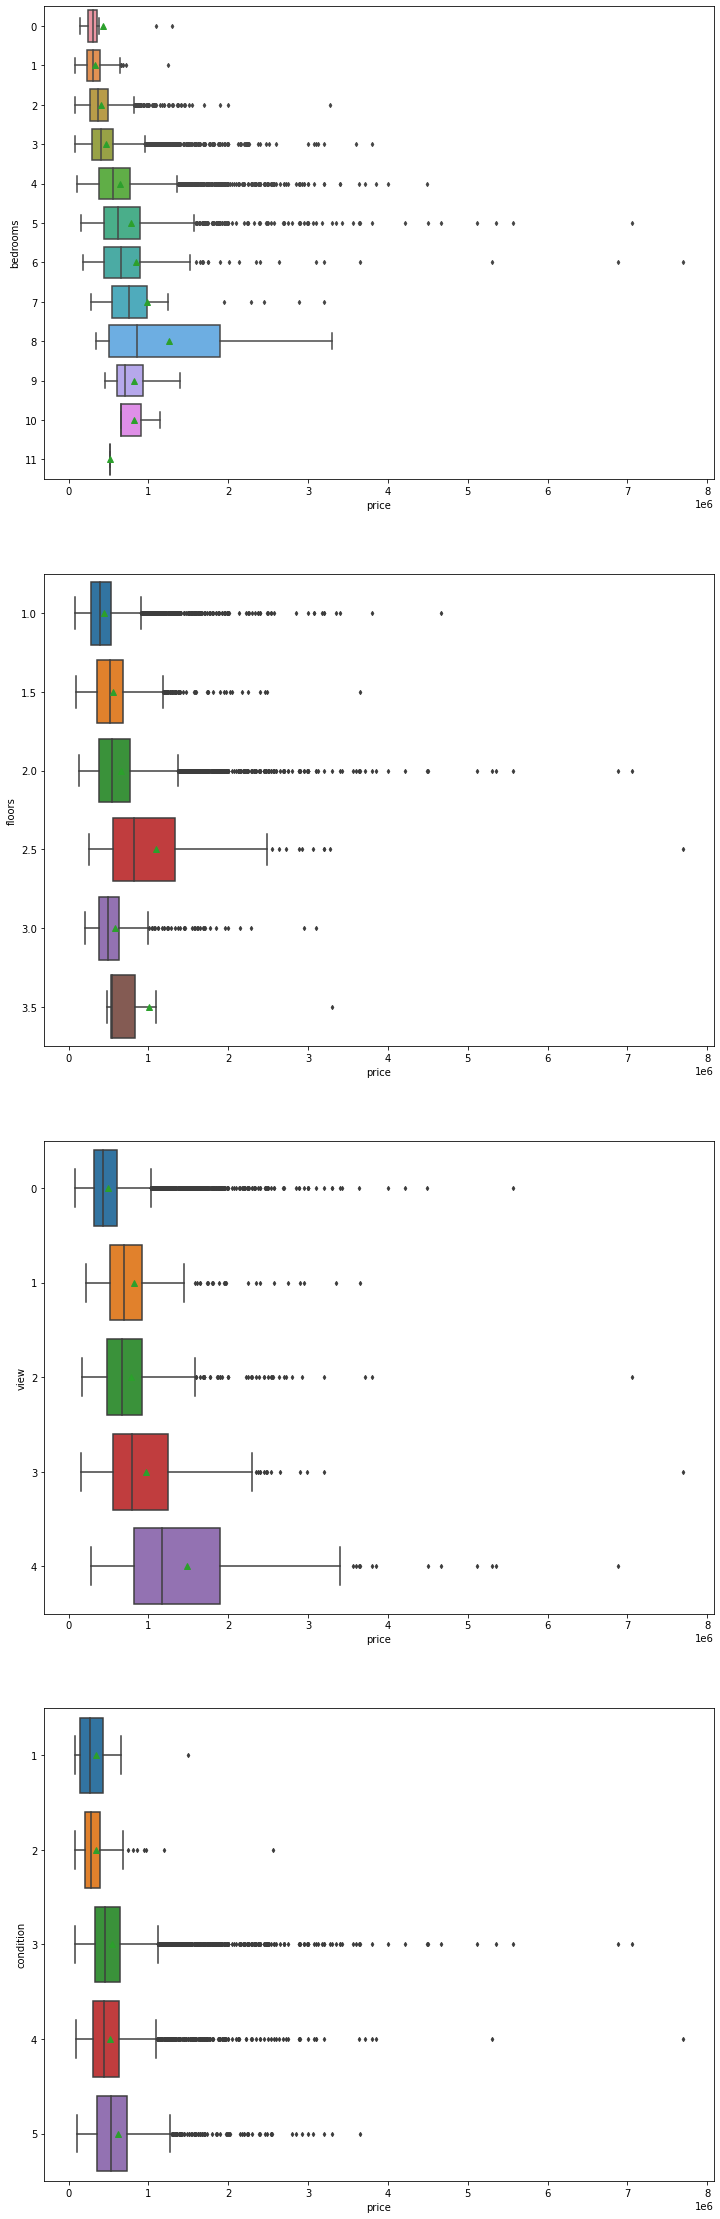

In [3308]:
fig, axarr = plt.subplots(4,figsize=(12,40))

sns.boxplot(y = 'bedrooms', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr[0])
sns.boxplot(y = 'floors', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr[1])
sns.boxplot(y = 'view', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr[2])
sns.boxplot(y = 'condition', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr[3])

plt.show()

#### Age Built by Bins

In [3309]:
bins = [-2, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 100000]
labels = ['<1', '1-10', '11-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100'] # e.g., (1-10]
df['age_built_binned'] = pd.cut(df['age_built'], bins = bins, labels = labels)

### Age of homes built by count

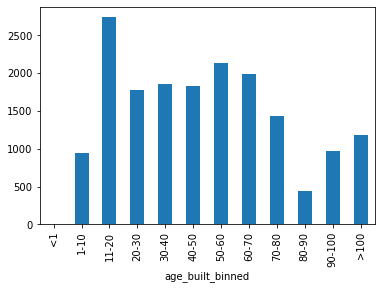

In [3310]:
df.groupby('age_built_binned')['price'].count().plot.bar()

# plt.savefig('age_built.png', dpi = 100)
plt.show()

### Age of Homes Built by Price

''

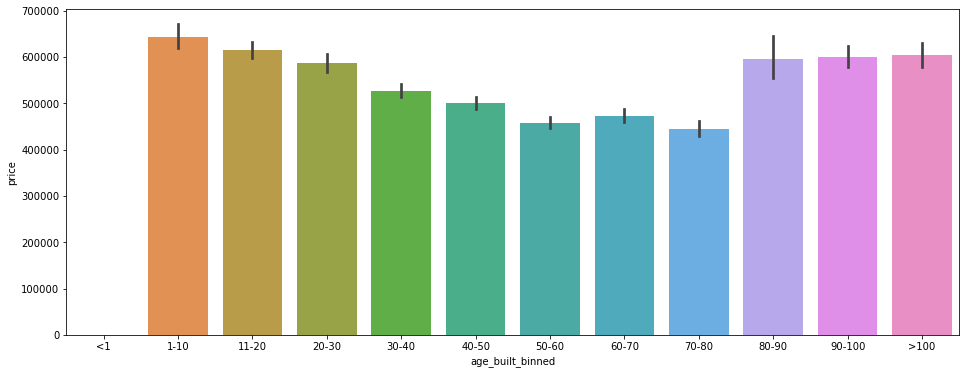

In [3311]:
x_line = df['age_built_binned']
y_line = df['price']

plt.figure(figsize=(16, 6))
sns.barplot(data = df, x = x_line, y = y_line)
# plt.savefig('age_built.png', dpi = 100)
;

### Sales by Season

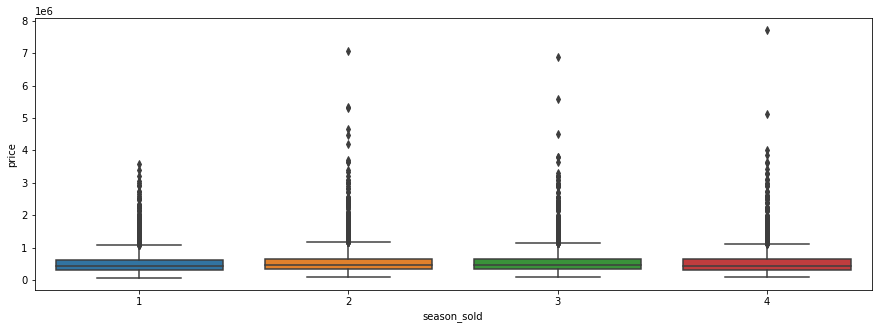

In [3312]:
plt.figure(figsize = (15,5))
x_box = df['season_sold']
y_box = df['price']

sns.boxplot(x = x_box, y = y_box, data = df);

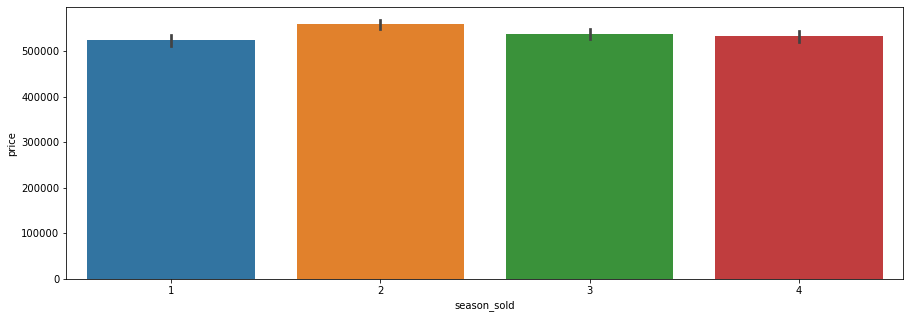

In [3313]:
plt.figure(figsize = (15,5))
x_bar = df['season_sold']
y_bar = df['price']

sns.barplot(x = x_box, y = y_box, data = df);

### Grade vs Price
- Let's take a closer look at **grade** vs **price** since there was a pretty nice correlation observed above.

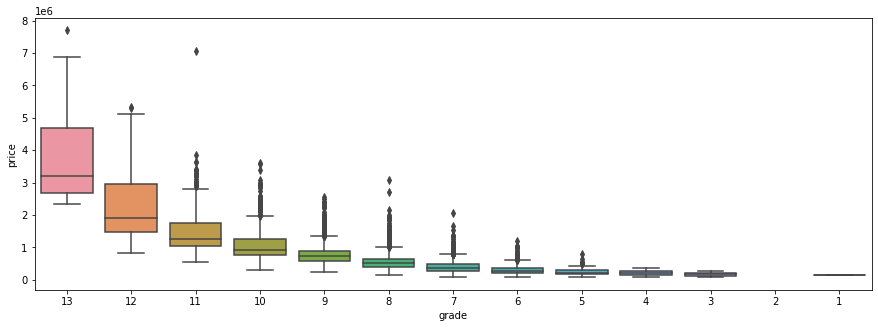

In [3314]:
plt.figure(figsize=(15, 5))
orders = list(reversed(range(1, 14))) #order of grade values in reverse order
sns.boxplot(x = df['grade'], y = df['price'], order = orders)

# plt.savefig('grade_vs_price_rev.png')
plt.show()

- We can see a pretty distinct association between the grade of a property, vs the price it fetched!

### Grade Counts by Sales

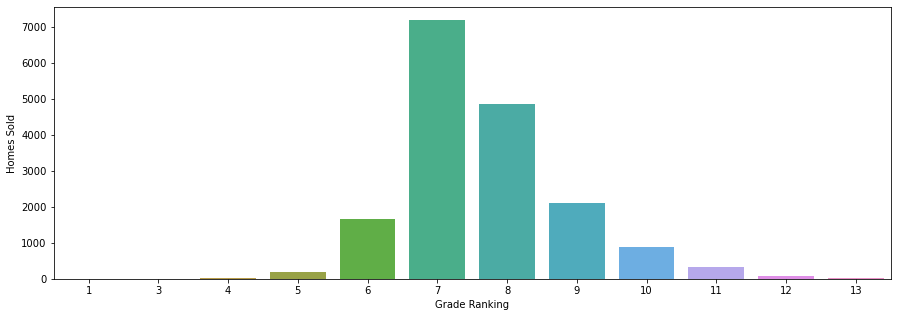

In [3315]:
plt.figure(figsize = (15,5))
x_bar_grade = df['grade'].value_counts().index
y_bar_grade = df['grade'].value_counts()

grade_bar = sns.barplot(x = x_bar_grade, y = y_bar_grade, data = df)
grade_bar.set(xlabel = "Grade Ranking", ylabel = "Homes Sold")
plt.show();

**Takeaways:**
- Ranks of 7 and 8 sold at a much higher rate than the other grade level rankings. Use 7-9 when creating feature interactions.

### Sales by Zipcode

#### Looking for the top performing zipcodes

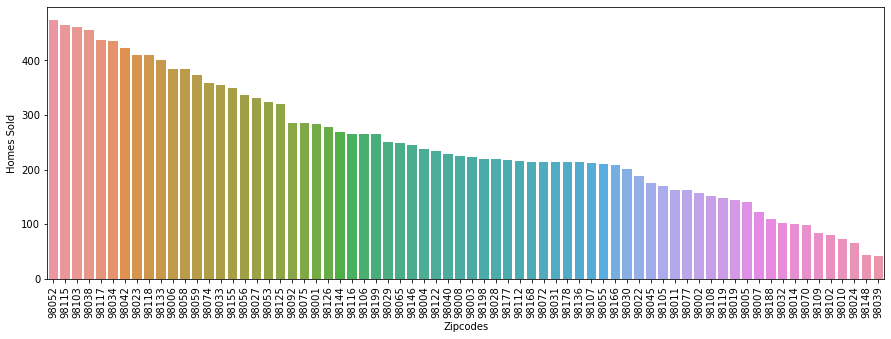

In [3316]:
plt.figure(figsize = (15,5))
x_bar_zip = df['zipcode'].value_counts().index
y_bar_zip = df['zipcode'].value_counts()

zip_bar = sns.barplot(x = x_bar_zip, y = y_bar_zip, data = df)
zip_bar.set_xticklabels(zip_bar.get_xticklabels(), rotation=90)
zip_bar.set(xlabel = "Zipcodes", ylabel = "Homes Sold")
plt.show();

### Top 20 Performing Zipcodes

In [3317]:
top_20_zip = ['98052', '98115', '98103', '98038', '98117', '98034', '98042', '98023', '98118', '98133', '98006', '98058', '98059', '98074', '98033', '98155', '98056', '98027', '98053', '98125']

In [3318]:
len(top_20_zip)

20

### Correlation Chart

In [3319]:
housing_corr = df.corr()

In [3320]:
#A look at correlation of all features
housing_corr

Unnamed: 0     price  bedrooms  bathrooms  sqft_living  \
Unnamed: 0         1.000000e+00 -0.012306 -0.010562  -0.005151    -0.008900   
price             -1.230630e-02  1.000000  0.313775   0.524838     0.703540   
bedrooms          -1.056203e-02  0.313775  1.000000   0.523016     0.588536   
bathrooms         -5.150856e-03  0.524838  0.523016   1.000000     0.755964   
sqft_living       -8.900440e-03  0.703540  0.588536   0.755964     1.000000   
sqft_lot          -3.500101e-03  0.086803  0.030674   0.085569     0.166810   
floors             1.059874e-02  0.256985  0.179908   0.498886     0.357169   
waterfront        -8.844970e-03  0.275779 -0.008668   0.065876     0.109738   
view              -6.278161e-07  0.395485  0.082724   0.189164     0.283336   
condition         -1.780728e-03  0.036099  0.021376  -0.123519    -0.061530   
grade             -5.014634e-03  0.666215  0.366405   0.664481     0.762929   
sqft_above        -3.406218e-03  0.607760  0.488420   0.687623     0.876696   
sqft_basement     -1.210401e-02  0.323312  0.307873   0.282700     0.435529   
yr_built           7.495925e-03  0.056450  0.159936   0.508450     0.319397   
yr_renovated      -3.423178e-03  0.117770  0.014489   0.048088     0.051448   
lat                2.469575e-03  0.302394 -0.003991   0.023026     0.052646   
long              -6.991705e-03  0.019327  0.129593   0.222025     0.234453   
sqft_living15     -8.961176e-03  0.585567  0.401073   0.568747     0.755066   
sqft_lot15         4.630729e-04  0.081423  0.028038   0.086658     0.179570   
year_sold         -3.019177e-03 -0.002334 -0.010211  -0.030027    -0.033606   
has_basement      -1.036513e-02  0.176970  0.163935   0.162319     0.203606   
age_built         -7.543576e-03 -0.056484 -0.160089  -0.508897    -0.319912   
last_reno         -8.349094e-03 -0.104828 -0.168892  -0.537872    -0.343313   
month_sold         3.138575e-03 -0.004350  0.002985   0.012926     0.017737   
season_sold       -1.180642e-03 -0.002850  0.002938   0.014045     0.019027   
was_reno          -3.421415e-03  0.117409  0.014182   0.047567     0.051159   
bed_sqft_ratio    -1.003727e-03 -0.474124  0.022666  -0.530903    -0.689571   
bath_sqft_ratio    3.390585e-03 -0.266844 -0.245144   0.191606    -0.435071   
floors_sqft_ratio  1.465490e-02 -0.306713 -0.437583  -0.266709    -0.548514   

                   sqft_lot    floors  waterfront          view  condition  \
Unnamed: 0        -0.003500  0.010599   -0.008845 -6.278161e-07  -0.001781   
price              0.086803  0.256985    0.275779  3.954851e-01   0.036099   
bedrooms           0.030674  0.179908   -0.008668  8.272411e-02   0.021376   
bathrooms          0.085569  0.498886    0.065876  1.891644e-01  -0.123519   
sqft_living        0.166810  0.357169    0.109738  2.833358e-01  -0.061530   
sqft_lot           1.000000 -0.002205    0.015356  7.305841e-02  -0.013715   
floors            -0.002205  1.000000    0.025132  2.588299e-02  -0.259230   
waterfront         0.015356  0.025132    1.000000  4.075653e-01   0.009608   
view               0.073058  0.025883    0.407565  1.000000e+00   0.045060   
condition         -0.013715 -0.259230    0.009608  4.505961e-02   1.000000   
grade              0.110320  0.458984    0.092234  2.495544e-01  -0.142066   
sqft_above         0.180755  0.528509    0.077162  1.647470e-01  -0.157466   
sqft_basement      0.008065 -0.247481    0.083433  2.799385e-01   0.166923   
yr_built           0.054228  0.483657   -0.021981 -4.959272e-02  -0.358921   
yr_renovated       0.004520  0.005985    0.094268  9.129115e-02  -0.060969   
lat               -0.082029  0.048227   -0.013331  3.819731e-03  -0.009927   
long               0.226190  0.128795   -0.042728 -7.757235e-02  -0.109200   
sqft_living15      0.136959  0.283933    0.091090  2.799990e-01  -0.094307   
sqft_lot15         0.701875 -0.008170    0.026895  7.318502e-02  -0.007125   
year_sold          0.003141 -0.024641   -0.000824  7.006991e-04  -0.044871   
has_basement

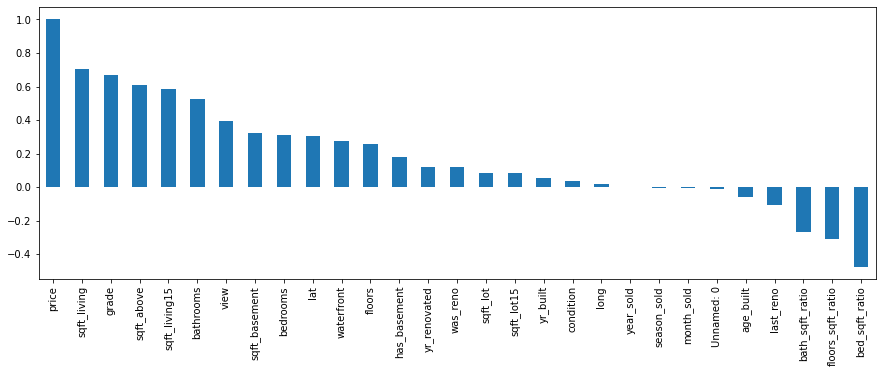

In [3321]:
housing_corr['price'].sort_values(ascending = False).plot.bar(figsize=(15,5))
plt.show()

**Takeaways:**
- We can clearly see the correlation between **price** and **sqft_living**, **grade**, **bathrooms**, and **view**.
- **Sqft_living15** also indicates the immediate neighbors and property values of those homes are correlated to the price as well.

### Correlation Heatmap

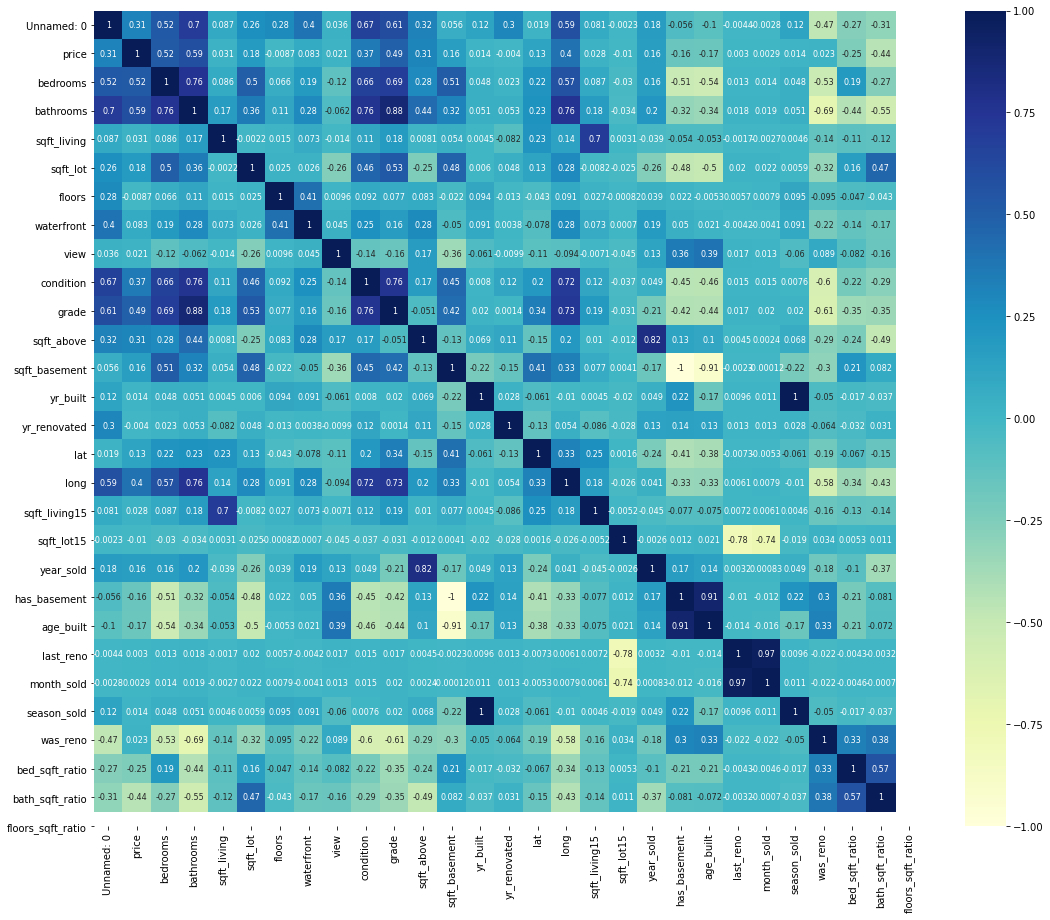

In [3322]:
plt.subplots(figsize=(20,15))

corr = housing_corr.iloc[1:,1:] #removes id column from heatmap
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

sns.heatmap(corr, 
    annot=True, 
    annot_kws={"fontsize":8},
    xticklabels = housing_corr.columns.values, # x labels
    yticklabels = housing_corr.columns.values, # y labels
    vmin = -1, # color scale the min value
    vmax = 1, # color scale the max
    center = 0, # color scale place at the center at 0
    cmap = "YlGnBu", # color palette
    square = True) # each cell will be square-shaped

# plt.savefig('corr_heat.png', dpi = 100)
plt.show()

**Takeaways:**
- **Month** and **season_sold** don't seem to be highly correlated to **price** here at all.
- **Renovations** might not have much impact on price also. As we already saw, most homes were quite new (bet. 11-20 years old).
- This helps solidify which features we should concentrate on looking at.

## Quick Correlation Look at Initial Summary Model

- Let's look at the summary model for our initial dataframe first (df)
- Since our initial inferences isolated grade, waterfront, and sqft_living as good indicators of correlation in relation to price, we'll take a look at those independent variables first.

### OLS Summary Model of Grade, Waterfront, and Sqft_living

In [3323]:
summary_model = ols(formula='price~grade+waterfront+sqft_living+was_reno', data = df).fit()
summary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     5953.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:20:20   Log-Likelihood:            -2.3888e+05
No. Observations:               17290   AIC:                         4.778e+05
Df Residuals:                   17285   BIC:                         4.778e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.017e+05   1.44e+04    -41.725      0.000    -6.3e+05   -5.73e+05
grade        9.898e+04   2428.159     40.763      0.000    9.42e+04    1.04e+05
waterfront   8.039e+05   2.09e+04     38.447      0.000    7.63e+05    8.45e+05
sqft_living   178.9822      3.109     57.577      0.000     172.889     185.075
was_reno     1.384e+05   9242.380     14.972      0.000     1.2e+05    1.56e+05
==============================================================================
Omnibus:                    13137.908   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           822210.647
Skew:                           3.110   Prob(JB):                         0.00
Kurtosis:                      36.206   Cond. No.                     2.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- As expected we see a high correlation with these features in relation to price.
- These variables only capture around 57% of all of our predictive values however.

### Looking at zipcodes

In [3324]:
#Use C(zipcode) to parse all zipcodes from that column properly if stored as int. Already changed to string so no need.
zip_model = ols(formula='price~zipcode', data = df).fit()
zip_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     167.4
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:20:20   Log-Likelihood:            -2.4193e+05
No. Observations:               17290   AIC:                         4.840e+05
Df Residuals:                   17220   BIC:                         4.845e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          2.82e+05   1.72e+04     16.421      0.000    2.48e+05    3.16e+05
zipcode[T.98002] -4.971e+04   2.88e+04     -1.727      0.084   -1.06e+05    6701.740
zipcode[T.98003]  8763.9215   2.59e+04      0.339      0.735   -4.19e+04    5.95e+04
zipcode[T.98004]  1.115e+06   2.55e+04     43.787      0.000    1.06e+06    1.16e+06
zipcode[T.98005]  5.268e+05   2.99e+04     17.629      0.000    4.68e+05    5.85e+05
zipcode[T.98006]  5.675e+05   2.26e+04     25.068      0.000    5.23e+05    6.12e+05
zipcode[T.98007]  3.156e+05   3.13e+04     10.073      0.000    2.54e+05    3.77e+05
zipcode[T.98008]  3.588e+05   2.58e+04     13.907      0.000    3.08e+05    4.09e+05
zipcode[T.98010]  1.429e+05   3.78e+04      3.783      0.000    6.88e+04    2.17e+05
zipcode[T.98011]  2.086e+05   2.84e+04      7.337      0.000    1.53e+05    2.64e+05
zipcode[T.98014]  1.742e+05   3.35e+04      5.196      0.000    1.08e+05     2.4e+05
zipcode[T.98019]  1.464e+05   2.95e+04      4.957      0.000    8.85e+04    2.04e+05
zipcode[T.98022]  2.677e+04   2.72e+04      0.985      0.324   -2.65e+04       8e+04
zipcode[T.98023]  7573.8820   2.23e+04      0.339      0.735   -3.62e+04    5.14e+04
zipcode[T.98024]   3.09e+05   3.98e+04      7.765      0.000    2.31e+05    3.87e+05
zipcode[T.98027]  3.253e+05   2.34e+04     13.907      0.000    2.79e+05    3.71e+05
zipcode[T.98028]  1.864e+05    2.6e+04      7.163      0.000    1.35e+05    2.37e+05
zipcode[T.98029]  3.337e+05   2.51e+04     13.295      0.000    2.84e+05    3.83e+05
zipcode[T.98030]   1.44e+04   2.67e+04      0.540      0.589   -3.79e+04    6.67e+04
zipcode[T.98031]   1.86e+04   2.62e+04      0.711      0.477   -3.27e+04    6.99e+04
zipcode[T.98032]  -3.04e+04   3.33e+04     -0.913      0.361   -9.56e+04    3.48e+04
zipcode[T.98033]  5.207e+05    2.3e+04     22.601      0.000    4.76e+05    5.66e+05
zipcode[T.98034]  2.419e+05   2.21e+04     10.955      0.000    1.99e+05    2.85e+05
zipcode[T.98038]  8.642e+04   2.19e+04      3.949      0.000    4.35e+04    1.29e+05
zipcode[T.98039]  1.921e+06   4.78e+04     40.147      0.000    1.83e+06    2.01e+06
zipcode[T.98040]   9.01e+05   2.57e+04     35.055      0.000    8.51e+05    9.51e+05
zipcode[T.98042]  2.717e+04   2.22e+04      1.224      0.221   -1.63e+04    7.07e+04
zipcode[T.98045]  1.493e+05   2.78e+04      5.378      0.000    9.49e+04    2.04e+05
zipcode[T.98052]  3.641e+05   2.17e+04     16.764      0.000    3.21e+05    4.07e+05
zipcode[T.98053]  3.953e+05   2.35e+04     16.805      0.000    3.49e+05    4.41e+05
zipcode[T.98055]  2.485e+04   2.63e+04      0.944      0.345   -2.68e+04    7.65e+04
zipcode[T.98056]  1.415e+05   2.33e+04      6.066      0.000    9.58e+04    1.87e+05
zipcode[T.98058]  7.237e+04   2.26e+04      3.197      0.001     2.8e+04    1.17e+05
zipcode[T.98059]  2.124

**Takeaways:**
- It may be better to look at the top zipcodes instead of all of them together.
- Perhaps top 10 would perform better?

## Creating Dummy Variables

- **Waterfront** (already 0s and 1s), **zipcode**, and **grade** (high correlation to price).

In [3325]:
#Create dummy variables for grade, waterfront, and zipcode
df = pd.get_dummies(df, columns = ['grade', 'waterfront', 'zipcode', 'season_sold', 'view', 'condition'], drop_first = True)

In [3326]:
df.head()

Unnamed: 0          id                      date      price  bedrooms  \
0           0  2591820310 2014-10-06 00:00:00+00:00   365000.0         4   
1           1  7974200820 2014-08-21 00:00:00+00:00   865000.0         5   
2           2  7701450110 2014-08-15 00:00:00+00:00  1038000.0         4   
3           3  9522300010 2015-03-31 00:00:00+00:00  1490000.0         3   
4           4  9510861140 2014-07-14 00:00:00+00:00   711000.0         3   

   bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  \
0       2.25         2070      8893     2.0        2070              0   
1       3.00         2900      6730     1.0        1830           1070   
2       2.50         3770     10893     2.0        3770              0   
3       3.50         4560     14608     2.0        4560              0   
4       2.50         2550      5376     2.0        2550              0   

   yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15  \
0      1986             0  47.4388 -122.162           2390        7700   
1      1977             0  47.6784 -122.285           2370        6283   
2      1997             0  47.5646 -122.129           3710        9685   
3      1990             0  47.6995 -122.228           4050       14226   
4      2004             0  47.6647 -122.083           2250        4050   

   year_sold  has_basement  age_built  last_reno  month_sold  was_reno  \
0       2014             0         34         34          10         0   
1       2014             1         43         43           8         0   
2       2014             0         23         23           8         0   
3       2015             0         31         31           3         0   
4       2014             0         16         16           7         0   

   bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio grade_lvl  \
0        0.001932         0.001087           0.000966        A-   
1        0.001724         0.001034           0.000345        A-   
2        0.001061         0.000663           0.000531        S-   
3        0.000658         0.000768           0.000439         S   
4        0.001176         0.000980           0.000784         A   

  age_built_binned  grade_3  grade_4  grade_5  grade_6  grade_7  grade_8  \
0            30-40        0        0        0        0        0        1   
1            40-50        0        0        0        0        0        1   
2            20-30        0        0        0        0        0        0   
3            30-40        0        0        0        0        0        0   
4            11-20        0        0        0        0        0        0   

   grade_9  grade_10  grade_11  grade_12  grade_13  waterfront_1  \
0        0         0         0         0         0             0   
1        0         0         0         0         0             0   
2        0         0         1         0         0             0   
3        0         0         0         1         0             0   
4        1         0         0         0         0             0   

   zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0

### Looking at Correlation of Dummies

In [3327]:
#Create new dataframe including dummy variables to check for correlation.
df_corr = df.corr()
df_corr

Unnamed: 0     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
Unnamed: 0     1.000000 -0.012306 -0.010562  -0.005151    -0.008900 -0.003500   
price         -0.012306  1.000000  0.313775   0.524838     0.703540  0.086803   
bedrooms      -0.010562  0.313775  1.000000   0.523016     0.588536  0.030674   
bathrooms     -0.005151  0.524838  0.523016   1.000000     0.755964  0.085569   
sqft_living   -0.008900  0.703540  0.588536   0.755964     1.000000  0.166810   
...                 ...       ...       ...        ...          ...       ...   
view_4        -0.001935  0.317456  0.038828   0.112392     0.178710  0.022213   
condition_2   -0.005793 -0.048513 -0.052935  -0.076889    -0.065621  0.041988   
condition_3    0.003457  0.006550  0.008839   0.189025     0.104360 -0.006863   
condition_4   -0.004357 -0.031574 -0.006531  -0.165016    -0.084267  0.006601   
condition_5    0.001670  0.058559  0.017442  -0.033717    -0.021026 -0.013745   

               floors  sqft_above  sqft_basement  yr_built  yr_renovated  \
Unnamed: 0   0.010599   -0.003406      -0.012104  0.007496     -0.003423   
price        0.256985    0.607760       0.323312  0.056450      0.117770   
bedrooms     0.179908    0.488420       0.307873  0.159936      0.014489   
bathrooms    0.498886    0.687623       0.282700  0.508450      0.048088   
sqft_living  0.357169    0.876696       0.435529  0.319397      0.051448   
...               ...         ...            ...       ...           ...   
view_4       0.024338    0.115175       0.155491 -0.015816      0.071099   
condition_2 -0.056070   -0.059759      -0.024408 -0.067830     -0.009227   
condition_3  0.312145    0.194242      -0.146822  0.388859      0.069417   
condition_4 -0.252076   -0.142895       0.092454 -0.253728     -0.052046   
condition_5 -0.119822   -0.087236       0.119592 -0.244772     -0.033816   

                  lat      long  sqft_living15  sqft_lot15  year_sold  \
Unnamed: 0   0.002470 -0.006992      -0.008961    0.000463  -0.003019   
price        0.302394  0.019327       0.585567    0.081423  -0.002334   
bedrooms    -0.003991  0.129593       0.401073    0.028038  -0.010211   
bathrooms    0.023026  0.222025       0.568747    0.086658  -0.030027   
sqft_living  0.052646  0.234453       0.755066    0.179570  -0.033606   
...               ...       ...            ...         ...        ...   
view_4       0.013310 -0.042353       0.161635    0.028620  -0.004236   
condition_2 -0.019768 -0.013615      -0.051270    0.020149   0.016735   
condition_3  0.038282  0.107630       0.115386   -0.008051   0.029739   
condition_4 -0.057107 -0.060466      -0.077115    0.016937  -0.006271   
condition_5  0.031544 -0.086042      -0.060466   -0.019533  -0.047080   

             has_basement  age_built  last_reno  month_sold  was_reno  \
Unnamed: 0      -0.010365  -0.007544  -0.008349    0.003139 -0.003421   
price            0.176970  -0.056484  -0.104828   -0.004350  0.117409   
bedrooms         0.163935  -0.160089  -0.168892    0.002985  0.014182   
bathrooms        0.162319  -0.508897  -0.537872    0.012926  0.047567   
sqft_living      0.203606  -0.319912  -0.343313    0.017737  0.051159   
...                   ...        ...        ...         ...       ...   
view_4           0.085665   0.015747  -0.005612    0.002986  0.071317   
condition_2     -0.010228   0.068093   0.074611   -0.012531 -0.009160   
condition_3     -0.118680  -0.388361  -0.427264   -0.007292  0.068858   
condition_4      0.076355   0.253612   0.282690   -0.003280 -0.051614   
condition_5      0.092086   0.244006   0.262712    0.021802 -0.033556   

             bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio   grade_3  \
Unnamed: 0        -0.001004         0.003391           0.014655 -0.002952   
price             -0.474124        -0.266844          -0.306713 -0.010725   
bedrooms           0.022666        -0.245144          -0.437583 -0.027963   
bathrooms         -0.530903         0.191606          -0.266709 -

### Looking at OLS Summary of Dummy Variables

In [3329]:
#From our final_dummy Dataframe
#Look at the dummy variables for waterfront and grade to see correlation against each ranking and waterfront property
dummy_model = ols(formula='price~waterfront_1+grade_lvl', data = df).fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     1881.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:22:32   Log-Likelihood:            -2.3914e+05
No. Observations:               17290   AIC:                         4.783e+05
Df Residuals:                   17277   BIC:                         4.784e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7.656e+05   5372.110    142.507      0.000    7.55e+05    7.76e+05
grade_lvl[T.A+]  2.853e+05   9831.040     29.019      0.000    2.66e+05    3.05e+05
grade_lvl[T.A-] -2.281e+05   6425.713    -35.504      0.000   -2.41e+05   -2.16e+05
grade_lvl[T.B]  -4.664e+05   8094.561    -57.615      0.000   -4.82e+05    -4.5e+05
grade_lvl[T.B+] -3.653e+05   6103.733    -59.852      0.000   -3.77e+05   -3.53e+05
grade_lvl[T.B-] -5.388e+05   1.85e+04    -29.059      0.000   -5.75e+05   -5.02e+05
grade_lvl[T.C]  -5.971e+05   1.74e+05     -3.432      0.001   -9.38e+05   -2.56e+05
grade_lvl[T.C+] -5.549e+05   5.27e+04    -10.529      0.000   -6.58e+05   -4.52e+05
grade_lvl[T.D]  -6.236e+05   2.46e+05     -2.535      0.011   -1.11e+06   -1.41e+05
grade_lvl[T.S]   1.423e+06   2.96e+04     48.043      0.000    1.37e+06    1.48e+06
grade_lvl[T.S+]  3.237e+06   7.43e+04     43.546      0.000    3.09e+06    3.38e+06
grade_lvl[T.S-]  6.987e+05   1.48e+04     47.190      0.000     6.7e+05    7.28e+05
waterfront_1     8.206e+05   2.12e+04     38.647      0.000    7.79e+05    8.62e+05
==============================================================================
Omnibus:                    11023.856   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           420653.407
Skew:                           2.510   Prob(JB):                         0.00
Kurtosis:                      26.637   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Takeaways:**
- We can see that the grade levels 'S+' and 'S-' have the highest positive correlation with price.
- Also the lower the grade the more that value will depreciate the sell value of the house.
- Whether or not the property was renovated also increases the value of the home by about 20,000k.

## Non-Linear Transformations

In [3330]:
#Check for continuous variables
df.dtypes

Unnamed: 0                   int64
id                          object
date           datetime64[ns, UTC]
price                      float64
bedrooms                     int32
                      ...         
view_4                       uint8
condition_2                  uint8
condition_3                  uint8
condition_4                  uint8
condition_5                  uint8
Length: 120, dtype: object

### Polynomial Transformations

#### Create a copy of the Dataframe with dummy variables already established

In [3331]:
final_housing = df.copy()

In [3332]:
final_housing.head()

Unnamed: 0          id                      date      price  bedrooms  \
0           0  2591820310 2014-10-06 00:00:00+00:00   365000.0         4   
1           1  7974200820 2014-08-21 00:00:00+00:00   865000.0         5   
2           2  7701450110 2014-08-15 00:00:00+00:00  1038000.0         4   
3           3  9522300010 2015-03-31 00:00:00+00:00  1490000.0         3   
4           4  9510861140 2014-07-14 00:00:00+00:00   711000.0         3   

   bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  \
0       2.25         2070      8893     2.0        2070              0   
1       3.00         2900      6730     1.0        1830           1070   
2       2.50         3770     10893     2.0        3770              0   
3       3.50         4560     14608     2.0        4560              0   
4       2.50         2550      5376     2.0        2550              0   

   yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15  \
0      1986             0  47.4388 -122.162           2390        7700   
1      1977             0  47.6784 -122.285           2370        6283   
2      1997             0  47.5646 -122.129           3710        9685   
3      1990             0  47.6995 -122.228           4050       14226   
4      2004             0  47.6647 -122.083           2250        4050   

   year_sold  has_basement  age_built  last_reno  month_sold  was_reno  \
0       2014             0         34         34          10         0   
1       2014             1         43         43           8         0   
2       2014             0         23         23           8         0   
3       2015             0         31         31           3         0   
4       2014             0         16         16           7         0   

   bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio grade_lvl  \
0        0.001932         0.001087           0.000966        A-   
1        0.001724         0.001034           0.000345        A-   
2        0.001061         0.000663           0.000531        S-   
3        0.000658         0.000768           0.000439         S   
4        0.001176         0.000980           0.000784         A   

  age_built_binned  grade_3  grade_4  grade_5  grade_6  grade_7  grade_8  \
0            30-40        0        0        0        0        0        1   
1            40-50        0        0        0        0        0        1   
2            20-30        0        0        0        0        0        0   
3            30-40        0        0        0        0        0        0   
4            11-20        0        0        0        0        0        0   

   grade_9  grade_10  grade_11  grade_12  grade_13  waterfront_1  \
0        0         0         0         0         0             0   
1        0         0         0         0         0             0   
2        0         0         1         0         0             0   
3        0         0         0         1         0             0   
4        1         0         0         0         0             0   

   zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0

In [3333]:
df['floors^2'] = df['floors'] ** 2
df['sqft_above^2'] = df['sqft_above'] ** 2
df['sqft_basement^2'] = df['sqft_basement'] ** 2
df['bath_sqft_ratio^2'] = df['bath_sqft_ratio'] ** 2
df['bed_sqft_ratio^2'] = df['bath_sqft_ratio'] ** 2
df['floors_sqft_ratio^2'] = df['floors_sqft_ratio'] ** 2
df['sqft_living^2'] = df['sqft_living'] ** 2
df['sqft_living15^2'] = df['sqft_living'] ** 2
df['sqft_lot^2'] = df['sqft_lot'] ** 2
df['sqft_lot15^2'] = df['sqft_lot15'] ** 2

### Interaction Features

In [3334]:
#Grades 7-9 had the highest sale rates, so we'll create interaction features for those three.
df['reno_basement'] = df['sqft_basement'] * df['was_reno']
df['sqft_reno'] = df['sqft_living'] * df['was_reno']
df['grade_7_sqft_living'] = df['sqft_living'] * df['grade_7']
df['grade_8_sqft_living'] = df['sqft_living'] * df['grade_8']
df['grade_9_sqft_living'] = df['sqft_living'] * df['grade_9']
df['floors_grade_7'] = df['floors'] * df['grade_7']
df['floors_grade_8'] = df['floors'] * df['grade_8']
df['floors_grade_9'] = df['floors'] * df['grade_9']

In [3335]:
df['waterfront_1'].dtype

dtype('uint8')

In [3336]:
df.head(3)

Unnamed: 0          id                      date      price  bedrooms  \
0           0  2591820310 2014-10-06 00:00:00+00:00   365000.0         4   
1           1  7974200820 2014-08-21 00:00:00+00:00   865000.0         5   
2           2  7701450110 2014-08-15 00:00:00+00:00  1038000.0         4   

   bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  \
0       2.25         2070      8893     2.0        2070              0   
1       3.00         2900      6730     1.0        1830           1070   
2       2.50         3770     10893     2.0        3770              0   

   yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15  \
0      1986             0  47.4388 -122.162           2390        7700   
1      1977             0  47.6784 -122.285           2370        6283   
2      1997             0  47.5646 -122.129           3710        9685   

   year_sold  has_basement  age_built  last_reno  month_sold  was_reno  \
0       2014             0         34         34          10         0   
1       2014             1         43         43           8         0   
2       2014             0         23         23           8         0   

   bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio grade_lvl  \
0        0.001932         0.001087           0.000966        A-   
1        0.001724         0.001034           0.000345        A-   
2        0.001061         0.000663           0.000531        S-   

  age_built_binned  grade_3  grade_4  grade_5  grade_6  grade_7  grade_8  \
0            30-40        0        0        0        0        0        1   
1            40-50        0        0        0        0        0        1   
2            20-30        0        0        0        0        0        0   

   grade_9  grade_10  grade_11  grade_12  grade_13  waterfront_1  \
0        0         0         0         0         0             0   
1        0         0         0         0         0             0   
2        0         0         1         0         0             0   

   zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              1   

   zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   ...  zipcode_98115  zipcode_98116  zipcode_98117  zipcode_98118  \
0  ...              0              0              0              0   
1  ...              1              0              0              0   
2  ...              0              0              0              0   

   zipcode_98119  zipcode_98122  zipcode_98125  zipcode_98126  zipcode_98133  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   zipcode_98136  zipcode_98144  zipcode_98146  zipcode_98148  zipcode_98155  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   zipcode_98166  zipcode_98168  zipcode_98177  zipcode_98178  zipcode_98188  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   zipcode_98198  zipcode_98199  season_sold_2  season_sold_3  season_sold

#### Run Summary Model on Interaction Features

In [3229]:
#Interaction Features
dummy_model = ols(formula='price~+reno_basement+sqft_reno+grade_7_sqft_living+grade_8_sqft_living+grade_9_sqft_living+floors_grade_7+floors_grade_8+floors_grade_9', data = df).fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     447.0
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:59:38   Log-Likelihood:            -2.4474e+05
No. Observations:               17290   AIC:                         4.895e+05
Df Residuals:                   17281   BIC:                         4.896e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             6.14e+05   5512.492    111.377      0.000    6.03e+05    6.25e+05
reno_basement         190.3885     29.244      6.510      0.000     133.067     247.710
sqft_reno             108.5717      8.019     13.539      0.000      92.854     124.290
grade_7_sqft_living   -29.6358      6.149     -4.819      0.000     -41.689     -17.582
grade_8_sqft_living    29.0889      5.169      5.627      0.000      18.957      39.221
grade_9_sqft_living   115.7411      7.843     14.758      0.000     100.369     131.114
floors_grade_7      -1.168e+05   7780.415    -15.018      0.000   -1.32e+05   -1.02e+05
floors_grade_8      -8.303e+04   6468.270    -12.837      0.000   -9.57e+04   -7.04e+04
floors_grade_9      -1.028e+05   1.21e+04     -8.479      0.000   -1.27e+05   -7.91e+04
==============================================================================
Omnibus:                    15577.119   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1023031.939
Skew:                           4.103   Prob(JB):                         0.00
Kurtosis:                      39.779   Cond. No.                     5.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Running Test Models against Training & Test Data

In [3230]:
print(df.columns.tolist())

['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'has_basement', 'age_built', 'last_reno', 'month_sold', 'was_reno', 'bed_sqft_ratio', 'bath_sqft_ratio', 'floors_sqft_ratio', 'grade_lvl', 'age_built_binned', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'waterfront_1', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipco

### Columns to be dropped

- **ID:** Not needed and irrelevant to analysis
- **Price:** Our target variable
- **Date:** Irrelevant now that we have year_sold
- **Sqft_lot15:** Sqft_living15 for nearest neighbors has a higher impact on home price. Lot is negative corr.
- **Last_reno:** Was_reno has better indication of making an impact on the price of the home rather then when it was renovated.
- **Month_sold:** Low relationship to price. Season a bit stronger.
- **Grade_lvl:** Multicolinearity with dummy variables for each grade score.
- **Age_built_binned:** Mostly was for plotting purposes, keep yr_built instead.
- **Zipcodes out of the top 20:** We'll look at zipcodes in the top 20 first.

In [3231]:
#Pull in previously identified top 20 zipcodes
top_20_zip

['98052',
 '98115',
 '98103',
 '98038',
 '98117',
 '98034',
 '98042',
 '98023',
 '98118',
 '98133',
 '98006',
 '98058',
 '98059',
 '98074',
 '98033',
 '98155',
 '98056',
 '98027',
 '98053',
 '98125']

#### Select Which Features to Use

In [3232]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built',
            'yr_renovated', 'lat', 'long', 'sqft_living15', 'year_sold', 'has_basement', 'age_built', 'was_reno',
            'bed_sqft_ratio', 'bath_sqft_ratio', 'floors_sqft_ratio', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
            'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'waterfront_1', 'zipcode_98052',
            'zipcode_98115', 'zipcode_98103', 'zipcode_98038', 'zipcode_98117', 'zipcode_98034', 'zipcode_98042', 
            'zipcode_98023', 'zipcode_98118', 'zipcode_98133', 'zipcode_98006', 'zipcode_98058', 'zipcode_98059',
            'zipcode_98074', 'zipcode_98033', 'zipcode_98155', 'zipcode_98056', 'zipcode_98027', 'zipcode_98053',
            'zipcode_98125', 'season_sold_2', 'season_sold_3', 'season_sold_4', 'view_1', 'view_2', 'view_3', 'view_4',
            'condition_2', 'condition_3', 'condition_4', 'condition_5', 'floors^2', 'sqft_above^2', 'sqft_basement^2',
            'bath_sqft_ratio^2', 'bed_sqft_ratio^2', 'floors_sqft_ratio^2', 'sqft_living^2', 'sqft_living15^2', 'sqft_lot^2',
            'sqft_lot15^2', 'reno_basement', 'sqft_reno', 'grade_7_sqft_living', 'grade_8_sqft_living', 'grade_9_sqft_living',
            'floors_grade_7', 'floors_grade_8', 'floors_grade_9']

#### Create Features and Target Variables

In [3233]:
df_features = df[features]
df_target = df['price']

### Train-Test Split the Data

In [3234]:
#Random state is the number to keep the train-test split consistent
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, random_state = 42, test_size=0.2)

### Unscaled Model

In [3235]:
def mlr_unscaled(features, target):
    
    #Instantiate a linear regression object
    lm = LinearRegression()
    
    #Fit the linear regression to the data
    lm = lm.fit(X_train, y_train)
    
    #Use the fitted model to predict on the training set and the test set.
    y_train_pred = lm.predict(X_train)
    y_test_pred = lm.predict(X_test)
    
    #Evaluate the training and test predictions using RMSE.
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    #View how far off we are in standard deviations of error
    rmse_distance = test_rmse/target.std()
    
    #View how far off from the mean absolute error of the target
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    mae_distance = test_mae/target.std()
    

    return {'train_rmse': train_rmse, 
            'test_rmse' : test_rmse,
            'std of error' : rmse_distance,
            'dist_from_mae' : mae_distance,
            'y_test_pred' : y_test_pred.mean()}

In [3236]:
mlr_unscaled(df_features, df_target)

{'train_rmse': 182708.47485837253,
 'test_rmse': 176485.3832983236,
 'std of error': 0.4727468822763791,
 'dist_from_mae': 0.2874846630962646,
 'y_test_pred': 531702.9760468785}

### Log Model

In [3237]:
def mlr_test_log_target(features, target):
    
    #Log the data to create a normal distribution
    y_log = np.log(y_train)
    
    #Instantiate a linear regression object
    lm_log = LinearRegression()
    
    #Fit the linear regression to the data
    lm_log = lm_log.fit(X_train, y_log)
    
    #Use the model to predict on the training set
    #Log_train_pred the predictions to get them on the same original scale 
    log_train_pred  = lm_log.predict(X_train)
    y_train_pred = np.exp(log_train_pred)
    
    #Use fitted model to predict on the test examples
    #Log_test_pred the predictions to get them back to original scale
    log_test_pred = lm_log.predict(X_test)
    y_test_pred = np.exp(log_test_pred)
 
    #Evaluate the training and test predictions using RMSE.
    log_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    #View how far off we are in standard deviations of error
    log_rmse_distance = log_test_rmse/target.std()
    
    #View how farr off from the mean absolute error of the target
    log_test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    log_mae_distance = log_test_mae/target.std()
    
    
    return {'log_train_rmse': log_train_rmse, 
            'log_test_rmse' : log_test_rmse,
            'std of error' : log_rmse_distance,
            'dist_from_mae' : log_mae_distance,
            'y_test_pred' : y_test_pred.mean()}

In [3238]:
mlr_test_log_target(df_features, df_target)

{'log_train_rmse': 178653.78757928527,
 'log_test_rmse': 175459.2484560281,
 'std of error': 0.4699982011197624,
 'dist_from_mae': 0.2619551460986875,
 'y_test_pred': 515095.8989904364}

## Select K-Best Model

In [3239]:
df.shape

(17290, 138)

In [3240]:
selector = SelectKBest(f_regression, k=70)

selector.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=70, score_func=<function f_regression at 0x0000028620E869D0>)

In [3241]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True])

In [3242]:
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [3243]:
list(removed_columns)

['year_sold',
 'grade_3',
 'grade_8',
 'zipcode_98117',
 'zipcode_98034',
 'zipcode_98059',
 'season_sold_3',
 'season_sold_4',
 'condition_3',
 'floors_grade_8']

In [3244]:
list(selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'has_basement',
 'age_built',
 'was_reno',
 'bed_sqft_ratio',
 'bath_sqft_ratio',
 'floors_sqft_ratio',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'waterfront_1',
 'zipcode_98052',
 'zipcode_98115',
 'zipcode_98103',
 'zipcode_98038',
 'zipcode_98042',
 'zipcode_98023',
 'zipcode_98118',
 'zipcode_98133',
 'zipcode_98006',
 'zipcode_98058',
 'zipcode_98074',
 'zipcode_98033',
 'zipcode_98155',
 'zipcode_98056',
 'zipcode_98027',
 'zipcode_98053',
 'zipcode_98125',
 'season_sold_2',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_2',
 'condition_4',
 'condition_5',
 'floors^2',
 'sqft_above^2',
 'sqft_basement^2',
 'bath_sqft_ratio^2',
 'bed_sqft_ratio^2',
 'floors_sqft_ratio^2',
 'sqft_living^2',
 'sqft_living15^2',
 'sqft_lot^2',
 'sqft_lot15^2'

In [3245]:
def mlr_Kbest(features, target):

    #instantiate a linear regression object
    lm_Kbest = LinearRegression()

    #fit the linear regression to the data
    lm_Kbest.fit(X_train[selected_columns], y_train)

    #Use the model to predict on the training and test set
    y_train_Kbest = lm_Kbest.predict(X_train[selected_columns])
    y_test_pred = lm_Kbest.predict(X_test[selected_columns])

    #Evaluate the training and test predictions using RMSE.
    trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_Kbest))
    testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    #View how far off we are in standard deviations of error
    rmseK_distance = testK_rmse/target.std()
    
    #View how farr off from the mean absolute error of the target
    testK_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    maeK_distance = testK_mae/target.std()


    return {'trainK_rmse': trainK_rmse, 
            'testK_rmse' : testK_rmse,
            'std of error' : rmseK_distance,
            'dist_from_mae' : maeK_distance,
            'y_test_pred' : y_test_pred.mean()}
#             'paired_coef' : list(zip(selected_columns, lm_Kbest.coef_))}

In [3246]:
mlr_Kbest(df_features, df_target)

{'trainK_rmse': 183594.6597452555,
 'testK_rmse': 177080.04817774257,
 'std of error': 0.47433979587914116,
 'dist_from_mae': 0.2902491875505212,
 'y_test_pred': 532140.8190055625}

## Recursive Feature Elimination

In [3247]:
ols = LinearRegression()
# Create recursive feature eliminator that scores features by mean squared errors
# Step means remove 1 feature at a time
# CV = cross validation, and is the number of train-test splits the model runs
# N_jobs runs separate models using separte cpu cores. Can set the number of cores to run on. (-1 runs on all available cores)
# Verbose gives feedback to show where the model is during the process. 
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit recursive feature eliminator       
# Can run on best K_model in place of X_train to combine the tests (selected_columns)
selector.fit(X_train, y_train) 

Fitting estimator with 80 features.
Fitting estimator with 79 features.


RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [3248]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [3249]:
list(removed_rfe)

['sqft_lot^2', 'sqft_lot15^2']

In [3250]:
len(selected_rfe)

78

In [3251]:
selected_rfe

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'year_sold', 'has_basement', 'age_built',
       'was_reno', 'bed_sqft_ratio', 'bath_sqft_ratio', 'floors_sqft_ratio',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'waterfront_1', 'zipcode_98052', 'zipcode_98115', 'zipcode_98103',
       'zipcode_98038', 'zipcode_98117', 'zipcode_98034', 'zipcode_98042',
       'zipcode_98023', 'zipcode_98118', 'zipcode_98133', 'zipcode_98006',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98074', 'zipcode_98033',
       'zipcode_98155', 'zipcode_98056', 'zipcode_98027', 'zipcode_98053',
       'zipcode_98125', 'season_sold_2', 'season_sold_3', 'season_sold_4',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'floo

In [3252]:
def mlr_rfe(features, target):
    
    #instantiate a linear regression object
    lm_rfe = LinearRegression()

    #fit the linear regression to the data
    lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)
    
    #Use the model to predict on the training and test set
    y_rfe = lm_rfe.predict(X_train[selected_rfe])
    y_test_pred = lm_rfe.predict(X_test[selected_rfe])

    #Evaluate the training and test predictions using RMSE.
    trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
    testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    #View how far off we are in standard deviations of error
    rmseRFE_distance = testRFE_rmse/target.std()
    
    #View how farr off from the mean absolute error of the target
    testRFE_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    maeRFE_distance = testRFE_mae/target.std()


    return {'trainRFE_rmse': trainRFE_rmse, 
            'testRFE_rmse' : testRFE_rmse,
            'std of error' : rmseRFE_distance,
            'dist_from_mae' : maeRFE_distance,
            'y_test_pred' : y_test_pred.mean()}

In [3253]:
mlr_rfe(df_features, df_target)

{'trainRFE_rmse': 182508.76875996107,
 'testRFE_rmse': 176805.0334982784,
 'std of error': 0.47360312109130814,
 'dist_from_mae': 0.2871823228711175,
 'y_test_pred': 531610.3422504651}

## Polynomial and Interaction Model

- Use the final_housing dataframe copy we created before transforming the data to use in the other models.

In [3254]:
final_housing.head()

Unnamed: 0          id                      date      price  bedrooms  \
0           0  2591820310 2014-10-06 00:00:00+00:00   365000.0         4   
1           1  7974200820 2014-08-21 00:00:00+00:00   865000.0         5   
2           2  7701450110 2014-08-15 00:00:00+00:00  1038000.0         4   
3           3  9522300010 2015-03-31 00:00:00+00:00  1490000.0         3   
4           4  9510861140 2014-07-14 00:00:00+00:00   711000.0         3   

   bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  \
0       2.25         2070      8893     2.0        2070              0   
1       3.00         2900      6730     1.0        1830           1070   
2       2.50         3770     10893     2.0        3770              0   
3       3.50         4560     14608     2.0        4560              0   
4       2.50         2550      5376     2.0        2550              0   

   yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15  \
0      1986             0  47.4388 -122.162           2390        7700   
1      1977             0  47.6784 -122.285           2370        6283   
2      1997             0  47.5646 -122.129           3710        9685   
3      1990             0  47.6995 -122.228           4050       14226   
4      2004             0  47.6647 -122.083           2250        4050   

   year_sold  has_basement  age_built  last_reno  month_sold  was_reno  \
0       2014             0         34         34          10         0   
1       2014             1         43         43           8         0   
2       2014             0         23         23           8         0   
3       2015             0         31         31           3         0   
4       2014             0         16         16           7         0   

   bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio grade_lvl  \
0        0.001932         0.001087           0.000966        A-   
1        0.001724         0.001034           0.000345        A-   
2        0.001061         0.000663           0.000531        S-   
3        0.000658         0.000768           0.000439         S   
4        0.001176         0.000980           0.000784         A   

  age_built_binned  grade_3  grade_4  grade_5  grade_6  grade_7  grade_8  \
0            30-40        0        0        0        0        0        1   
1            40-50        0        0        0        0        0        1   
2            20-30        0        0        0        0        0        0   
3            30-40        0        0        0        0        0        0   
4            11-20        0        0        0        0        0        0   

   grade_9  grade_10  grade_11  grade_12  grade_13  waterfront_1  \
0        0         0         0         0         0             0   
1        0         0         0         0         0             0   
2        0         0         1         0         0             0   
3        0         0         0         1         0             0   
4        1         0         0         0         0             0   

   zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98007  zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0

In [3255]:
#Checking to see sizes of both Dataframes
print(final_housing.shape)
print(df.shape)

(17290, 120)
(17290, 138)


#### Generate Polynomial and Interaction features

In [3256]:
#Create Polynomial and Interaction Features

#Drop non-numerical and categorical values that would break code below
final_housing.drop('price', axis=1, inplace=True)
final_housing.drop('date', axis=1, inplace=True)
final_housing.drop('grade_lvl', axis=1, inplace=True)
final_housing.drop('age_built_binned', axis=1, inplace=True)
final_housing.drop('id', axis=1, inplace=True)
final_housing.drop('lat', axis=1, inplace=True)
final_housing.drop('long', axis=1, inplace=True)

#Polynomial and Interaction Creation
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(final_housing)
poly2_columns = poly_2.get_feature_names(final_housing.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

Unnamed: 0  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  \
0         0.0       4.0       2.25       2070.0    8893.0     2.0      2070.0   
1         1.0       5.0       3.00       2900.0    6730.0     1.0      1830.0   
2         2.0       4.0       2.50       3770.0   10893.0     2.0      3770.0   
3         3.0       3.0       3.50       4560.0   14608.0     2.0      4560.0   
4         4.0       3.0       2.50       2550.0    5376.0     2.0      2550.0   

   sqft_basement  yr_built  yr_renovated  sqft_living15  sqft_lot15  \
0            0.0    1986.0           0.0         2390.0      7700.0   
1         1070.0    1977.0           0.0         2370.0      6283.0   
2            0.0    1997.0           0.0         3710.0      9685.0   
3            0.0    1990.0           0.0         4050.0     14226.0   
4            0.0    2004.0           0.0         2250.0      4050.0   

   year_sold  has_basement  age_built  last_reno  month_sold  was_reno  \
0     2014.0           0.0       34.0       34.0        10.0       0.0   
1     2014.0           1.0       43.0       43.0         8.0       0.0   
2     2014.0           0.0       23.0       23.0         8.0       0.0   
3     2015.0           0.0       31.0       31.0         3.0       0.0   
4     2014.0           0.0       16.0       16.0         7.0       0.0   

   bed_sqft_ratio  bath_sqft_ratio  floors_sqft_ratio  grade_3  grade_4  \
0        0.001932         0.001087           0.000966      0.0      0.0   
1        0.001724         0.001034           0.000345      0.0      0.0   
2        0.001061         0.000663           0.000531      0.0      0.0   
3        0.000658         0.000768           0.000439      0.0      0.0   
4        0.001176         0.000980           0.000784      0.0      0.0   

   grade_5  grade_6  grade_7  grade_8  grade_9  grade_10  grade_11  grade_12  \
0      0.0      0.0      0.0      1.0      0.0       0.0       0.0       0.0   
1      0.0      0.0      0.0      1.0      0.0       0.0       0.0       0.0   
2      0.0      0.0      0.0      0.0      0.0       0.0       1.0       0.0   
3      0.0      0.0      0.0      0.0      0.0       0.0       0.0       1.0   
4      0.0      0.0      0.0      0.0      1.0       0.0       0.0       0.0   

   grade_13  waterfront_1  zipcode_98002  zipcode_98003  zipcode_98004  \
0       0.0           0.0            0.0            0.0            0.0   
1       0.0           0.0            0.0            0.0            0.0   
2       0.0           0.0            0.0            0.0            0.0   
3       0.0           0.0            0.0            0.0            0.0   
4       0.0           0.0            0.0            0.0            0.0   

   zipcode_98005  zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            1.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  zipcode_98023  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98024  zipcode_98027  zipcode_98028  zipcode_98029  ...  \
0            0.0            0.0            0.0            0.0  ...   
1            0.0            0.0            0.0            0.0  ...   
2            0.0            0.0            0.0            0.0  ...   
3            0.0         

#### Get rid of polynomial columns that have all 0 values

In [3257]:
# df_poly_clean = df_poly2.loc[:, (df_poly2 != 0).any(axis=0)]
# df_poly_clean.head()

#### Create Feature and Target Variables for Polynomial and Interaction Variables

In [3258]:
poly_features = df_poly2[poly2_columns]

#### Train-Test Split the df_poly_clean Dataframe

In [3259]:
#Random state is the number to keep the train-test split consistent
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(poly_features, df_target, random_state = 42, test_size=0.2)

In [3339]:
def mlr_poly(features, target):
    
    #Instantiate a linear regression object
    lm_poly = LinearRegression()
    
    #Fit the linear regression to the data
    lm_poly = lm_poly.fit(X_train_poly, y_train_poly)
    
    #Use the fitted model to predict on the training set and the test set.
    y_train_pred_poly = lm_poly.predict(X_train_poly)
    y_test_pred = lm_poly.predict(X_test_poly)
    
    #Evaluate the training and test predictions using RMSE.
    train_rmse_poly = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_pred_poly))
    test_rmse_poly = np.sqrt(metrics.mean_squared_error(y_test_poly, y_test_pred))
    
    #View how far off we are in standard deviations of error
    rmse_distance_poly = test_rmse_poly/target.std()
    
    #View how far off from the mean absolute error of the target
    test_mae_poly = metrics.mean_absolute_error(y_test_poly, y_test_pred)
    mae_distance_poly = test_mae_poly/target.std()
    

    return {'train_rmse': train_rmse_poly, 
            'test_rmse' : test_rmse_poly,
            'std of error' : rmse_distance_poly,
            'dist_from_mae' : mae_distance_poly,
            'y_test_pred' : y_test_pred.mean()}

In [3340]:
mlr_poly(poly_features, df_target)

{'train_rmse': 87133.72489233244,
 'test_rmse': 76638345.20257708,
 'std of error': 205.28917511597322,
 'dist_from_mae': 4.372930203826928,
 'y_test_pred': -707380.7724313632}

## Polynomial w/ K-Best Model

In [3341]:
poly_selector = SelectKBest(f_regression, k=700)

poly_selector.fit(X_train_poly, y_train_poly)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=700, score_func=<function f_regression at 0x0000028620E869D0>)

In [3342]:
poly_selector.get_support()

array([False,  True,  True, ..., False, False, False])

In [3343]:
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]
poly_selected_columns = X_train_poly.columns[poly_selector.get_support()]
poly_removed_columns = X_train_poly.columns[~poly_selector.get_support()]

In [3344]:
list(poly_removed_columns)

['Unnamed: 0',
 'sqft_lot',
 'yr_built',
 'sqft_lot15',
 'year_sold',
 'age_built',
 'month_sold',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_8',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98005',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98119',
 'zipco

In [3345]:
list(poly_selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_renovated',
 'sqft_living15',
 'has_basement',
 'last_reno',
 'was_reno',
 'bed_sqft_ratio',
 'bath_sqft_ratio',
 'floors_sqft_ratio',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'waterfront_1',
 'zipcode_98004',
 'zipcode_98006',
 'zipcode_98023',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98112',
 'view_2',
 'view_3',
 'view_4',
 'Unnamed: 0 bedrooms',
 'Unnamed: 0 bathrooms',
 'Unnamed: 0 sqft_living',
 'Unnamed: 0 floors',
 'Unnamed: 0 sqft_above',
 'Unnamed: 0 sqft_basement',
 'Unnamed: 0 sqft_living15',
 'Unnamed: 0 has_basement',
 'Unnamed: 0 bed_sqft_ratio',
 'Unnamed: 0 bath_sqft_ratio',
 'Unnamed: 0 floors_sqft_ratio',
 'Unnamed: 0 grade_6',
 'Unnamed: 0 grade_7',
 'Unnamed: 0 grade_9',
 'Unnamed: 0 grade_10',
 'Unnamed: 0 grade_11',
 'Unnamed: 0 grade_12',
 'Unnamed: 0 grade_13',
 'Unnamed: 0 waterfront_1',
 'Unnamed: 0 zipcode_98004',
 

In [3346]:
def mlr_poly_Kbest(features, target):

    #instantiate a linear regression object
    lm_poly_Kbest = LinearRegression()

    #fit the linear regression to the data
    lm_poly_Kbest.fit(X_train_poly[poly_selected_columns], y_train_poly)

    #Use the model to predict on the training and test set
    y_train_poly_Kbest = lm_poly_Kbest.predict(X_train_poly[poly_selected_columns])
    y_poly_Kbest = lm_poly_Kbest.predict(X_test_poly[poly_selected_columns])

    #Evaluate the training and test predictions using RMSE.
    train_poly_K_rmse = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_poly_Kbest))
    test_poly_K_rmse = np.sqrt(metrics.mean_squared_error(y_test_poly, y_poly_Kbest))
    
    #View how far off we are in standard deviations of error
    rmse_poly_K_distance = test_poly_K_rmse/target.std()
    
    #View how farr off from the mean absolute error of the target
    test_poly_K_mae = metrics.mean_absolute_error(y_test_poly, y_test_pred)
    mae_poly_K_distance = test_poly_K_mae/target.std()


    return {'train_poly_K_rmse': train_poly_K_rmse, 
            'test_poly_K_rmse' : test_poly_K_rmse,
            'std of error' : rmse_poly_K_distance,
            'dist_from_mae' : mae_poly_K_distance,
            'y_test_pred' : y_test_pred.mean()}
#             'paired_coef' : list(zip(poly_selected_columns, lm_poly_Kbest.coef_))}

In [3347]:
mlr_poly_Kbest(poly_features, df_target)

{'train_poly_K_rmse': 135399.89423866107,
 'test_poly_K_rmse': 191614.65370692543,
 'std of error': 0.5132732719587065,
 'dist_from_mae': 0.2874846630962646,
 'y_test_pred': 531702.9760468785}

## Selecting the Best Model 

In [3348]:
mlr_unscaled(df_features, df_target)

{'train_rmse': 182708.47485837253,
 'test_rmse': 176485.3832983236,
 'std of error': 0.4727468822763791,
 'dist_from_mae': 0.2874846630962646,
 'y_test_pred': 531702.9760468785}

In [3349]:
mlr_test_log_target(df_features, df_target)

{'log_train_rmse': 178653.78757928527,
 'log_test_rmse': 175459.2484560281,
 'std of error': 0.4699982011197624,
 'dist_from_mae': 0.2619551460986875,
 'y_test_pred': 515095.8989904364}

In [3350]:
mlr_Kbest(df_features, df_target)

{'trainK_rmse': 183594.6597452555,
 'testK_rmse': 177080.04817774257,
 'std of error': 0.47433979587914116,
 'dist_from_mae': 0.2902491875505212,
 'y_test_pred': 532140.8190055625}

In [3351]:
mlr_rfe(df_features, df_target)

{'trainRFE_rmse': 182508.76875996107,
 'testRFE_rmse': 176805.0334982784,
 'std of error': 0.47360312109130814,
 'dist_from_mae': 0.2871823228711175,
 'y_test_pred': 531610.3422504651}

In [3273]:
mlr_poly(poly_features, df_target)

{'train_rmse': 87133.72489233244,
 'test_rmse': 76638345.20257708,
 'std of error': 205.28917511597322,
 'dist_from_mae': 0.2874846630962646,
 'y_test_pred': 531702.9760468785}

In [3352]:
mlr_poly_Kbest(poly_features, df_target)

{'train_poly_K_rmse': 135399.89423866107,
 'test_poly_K_rmse': 191614.65370692543,
 'std of error': 0.5132732719587065,
 'dist_from_mae': 0.2874846630962646,
 'y_test_pred': 531702.9760468785}

#### Log Test Will Be Our Final Model
- Lowest test_rmse score of: 175459.2484560281
- Lowest prediction mean of: 515095.8989904364
- Lowest std of error of: 0.4699982011197624
- Lowest dist_from_mae of: 0.2619551460986875

## Fit Best Model to Entire Dataset

In [3362]:
final_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built',
            'yr_renovated', 'lat', 'long', 'sqft_living15', 'year_sold', 'has_basement', 'age_built', 'was_reno',
            'bed_sqft_ratio', 'bath_sqft_ratio', 'floors_sqft_ratio', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
            'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'waterfront_1', 'zipcode_98052',
            'zipcode_98115', 'zipcode_98103', 'zipcode_98038', 'zipcode_98117', 'zipcode_98034', 'zipcode_98042', 
            'zipcode_98023', 'zipcode_98118', 'zipcode_98133', 'zipcode_98006', 'zipcode_98058', 'zipcode_98059',
            'zipcode_98074', 'zipcode_98033', 'zipcode_98155', 'zipcode_98056', 'zipcode_98027', 'zipcode_98053',
            'zipcode_98125', 'season_sold_2', 'season_sold_3', 'season_sold_4', 'view_1', 'view_2', 'view_3', 'view_4',
            'condition_2', 'condition_3', 'condition_4', 'condition_5', 'floors^2', 'sqft_above^2', 'sqft_basement^2',
            'bath_sqft_ratio^2', 'bed_sqft_ratio^2', 'floors_sqft_ratio^2', 'sqft_living^2', 'sqft_living15^2', 'sqft_lot^2',
            'sqft_lot15^2', 'reno_basement', 'sqft_reno', 'grade_7_sqft_living', 'grade_8_sqft_living', 'grade_9_sqft_living',
            'floors_grade_7', 'floors_grade_8', 'floors_grade_9']

In [3363]:
final_features = df[final_columns]

In [3371]:
#Log the data to create a normal distribution
lm_final_y_intercept = np.log(df_target)

#Instantiate a linear regression object
lm_final = LinearRegression()

#Fit the linear regression to the data
lm_final = lm_final.fit(final_features, lm_final_y_intercept)

In [3372]:
#R^2 Score
lm_final.score(final_features, lm_final_y_intercept)

0.8035768762848867

In [3373]:
print(lm_final.intercept_)
print(lm_final.coef_)
print(len(lm_final.coef_))

-239.16794474339792
[-3.13285383e-03  6.94834395e-02 -1.22589088e-01  4.75272452e-07
  1.55360470e-03  1.22811921e-01  1.22675207e-01  2.71753358e-02
  4.75872194e-03  1.46689107e+00 -2.07385929e-01  8.92007601e-05
  5.00905554e-02  6.40702410e-02  2.97634278e-02 -9.46960841e+00
 -2.53752302e+01 -3.15350701e+01 -4.17227676e+01 -4.84731381e-02
 -1.16062438e-01 -8.74715928e-02  4.05242192e-02  2.08472864e-01
  3.31450659e-01  5.71989507e-01  5.82071441e-01  6.83943626e-01
  8.18832024e-01  1.05647132e+00  4.41268952e-01 -5.36597328e-03
  7.11331397e-02  7.81227745e-02  5.18115220e-02  5.67958928e-02
 -1.50275578e-01 -6.48783155e-02 -1.37056632e-01 -2.59804143e-02
 -3.04162083e-01  1.24838692e-01 -1.02735471e-01 -3.25772602e-03
 -2.30321814e-04  1.14289524e-01 -3.39537263e-01 -5.81311622e-02
  1.13717127e-01  1.26323912e-02 -1.70978518e-01  4.48835669e-02
  4.89279559e-02  4.73500773e-02  1.56459288e-01  1.11171181e-01
  1.56369535e-01  2.28121983e-01  9.24141272e-02  1.97984832e-01
  2.6

In [3360]:
# pickle_out = open("final_model.pickle","wb")
# pickle.dump(lm_final, pickle_out)
# pickle_out.close()

In [3167]:
#Bring in final info that do not want to run again on holdout data
# other_info = [final_columns]

In [3168]:
# pickle_out = open('other_info.pickle', "wb")
# pickle.dump(other_info, pickle_out)
# pickle_out.close()